Edric Franco -
12/2018


Let us forecast Apple stock prices (Ticker = 'AAPL') <br>
Using the TwitterBot_Model.py we created:

- Let us first Scrape Twitter data
- Apply sentiment analysis
- Merge prices of stock

In [1]:
%%capture
from TwitterBot_Model import Twitter_Sentiment_Bot
import datetime as dt

ticker='AAPL'
begin_date=dt.date(2018,1 ,1)
end_date= dt.date(2018, 12, 31)

scrap = Twitter_Sentiment_Bot(ticker=ticker,
                              begin_date=begin_date,
                              end_date=end_date)

limit = 5
lang = 'english'
scrap.run_all(limit=limit,
                   lang=lang)
df = scrap.df

In [2]:
df.head()

,Date,sentiment,Adj Close
0,2018-01-01,0.133553,NaN
1,2018-01-02,0.390492,166.353714
2,2018-01-03,0.136420,166.324722
3,2018-01-04,0.023194,167.097290
4,2018-01-05,0.308095,168.999741


- Our plan is to first use the Sentiment Scores we got from TwitterBot_Model.py to model Stock Prices for Apple
- We then use Time Series Analysis to model the residuals of our predictions
- This is a variation of the standard ARIMAX model where we use another machine learning model instead of standard linear regression

In [3]:
# Import Packages

import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
import matplotlib.pyplot as plt
from pyramid.arima import auto_arima

# We model log prices for numerical stability
# Train on first 200 days of the trading year, Test on last 50 trading days
df = df.set_index('Date')
df = df.dropna(axis=0)
df['log_price'] = np.log(df['Adj Close']) # log prices
df.index = pd.to_datetime(df.index)
df_train = df[:200] # first  200 stock prices
df_test = df[200:] # test on last month stock prices

C:\Users\Edric\Anaconda3\lib\site-packages\pyramid\__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


Let us first explore the relationship between the Sentiment Scores and the Stock Prices

Text(0.5, 1.0, 'Sentiment Scores vs. Log Prices')

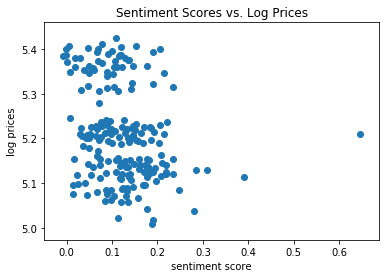

In [4]:
plt.scatter(x=df_train['sentiment'], y=df_train['log_price'])
plt.xlabel('sentiment score')
plt.ylabel('log prices')
plt.title('Sentiment Scores vs. Log Prices')

- It appears that Sentiment Scores and Log Prices do not have a linear relationship
- An SVM regressor with a RBF kernel appears to be a good model

In [5]:
from sklearn.svm import SVR
from hyperparameters import SVM_PARAMS

model_SVR = SVR(**SVM_PARAMS)
model_SVR.fit(df_train[['sentiment']], df_train[['log_price']])
df_train['pred'] = model_SVR.predict(df_train[['sentiment']])
df_test['pred'] = model_SVR.predict(df_test[['sentiment']])
df_train['residuals'] = df_train['log_price'] - df_train['pred']
df_test['residuals'] = df_test['log_price'] - df_test['pred']
# We now fit a time series  model to the residuals

C:\Users\Edric\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Edric\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Edric\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Edric\Anaconda3\lib\site-package

Text(0, 0.5, 'Residuals')

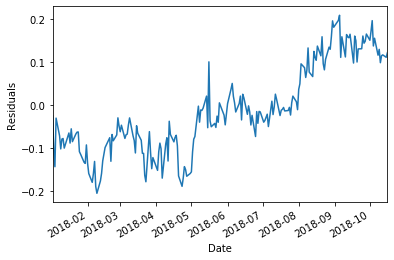

In [6]:
# Plot Time Series
df_train['residuals'].plot()
plt.ylabel('Residuals')

C:\Users\Edric\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


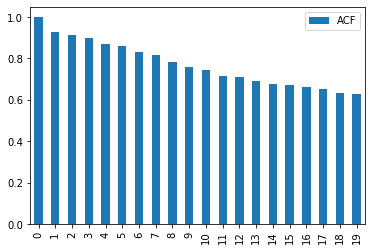

In [7]:
acf_1 = acf(df_train['residuals'])[0:20]
df_1 = pd.DataFrame([acf_1]).T
df_1.columns=['ACF']
df_1.plot(kind='bar')

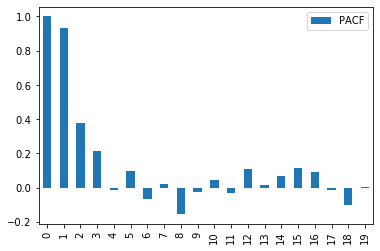

In [8]:
pacf_1 = pacf(df_train['residuals'])[0:20]
df_1 = pd.DataFrame([pacf_1]).T
df_1.columns=['PACF']
df_1.plot(kind='bar')

We can see from the Time Series Plot:
- There appears to be an upward trend

We can see that the ACF tends to tail off very slowly:
- This could be a sign that our Series is integrated
- Let us take the first order difference

C:\Users\Edric\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


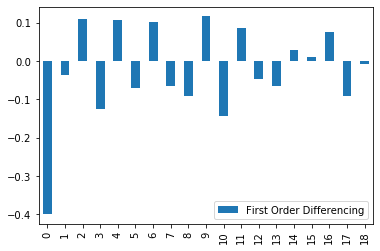

In [9]:
res_diff = df_train['residuals'] - df_train['residuals'].shift()
res_diff = res_diff.dropna()
acf_1_diff = acf(res_diff)[1:20]
test_df = pd.DataFrame([acf_1_diff]).T
test_df.columns = ['First Order Differencing']
test_df.plot(kind='bar')

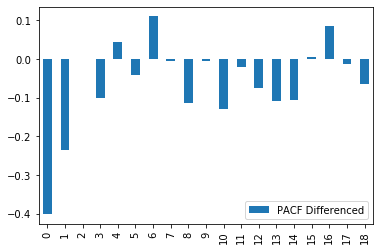

In [10]:
pacf_1_diff = pacf(res_diff)[1:20]
df = pd.DataFrame([pacf_1_diff]).T
df.columns=['PACF Differenced']
df.plot(kind='bar')

- There appears to be seasonality in the residuals of our predictions
- Let us use auto arima to find the parameters that minimize AIC

In [11]:
from pyramid.arima import auto_arima
from hyperparameters import ARIMA_PARAMS

ts_model = auto_arima(df_train['residuals'], **ARIMA_PARAMS)
print(ts_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-701.034, BIC=-684.878, Fit time=1.743 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-583.300, BIC=-576.838, Fit time=0.051 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-645.057, BIC=-632.133, Fit time=0.654 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-694.994, BIC=-682.070, Fit time=0.701 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-698.654, BIC=-679.267, Fit time=2.168 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-605.039, BIC=-592.114, Fit time=0.376 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-698.184, BIC=-678.798, Fit time=4.169 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-697.610, BIC=-674.992, Fit time=8.329 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-701.245, BIC=-681.858, Fit time=2.717 seconds
Fit ARIMA: order=(2, 1, 0) s

Let us now predict our residuals

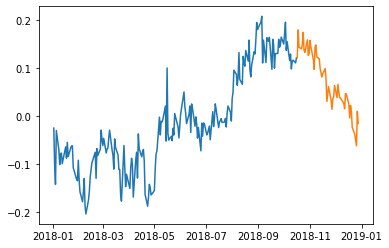

In [12]:
resid_preds=[]
for day in range(50):
    resid = pd.concat([df_train[['residuals']], df_test[['residuals']].iloc[day-1:day]])
    ts_model.fit(resid)
    pred = ts_model.predict(n_periods=1)
    resid_preds.append(pred[0])
    
df_test['forecasted_residuals'] = resid_preds
plt.plot(df_train['residuals'])
plt.plot(df_test['forecasted_residuals'])
plt.show()

- We now add the residuals to the predictions of our SVM regressor
- We then validate our model using the hold out test set

In [13]:
df_test['Forecast'] = df_test['pred'] + df_test['forecasted_residuals']

Text(0, 0.5, 'log Apple stock prices')

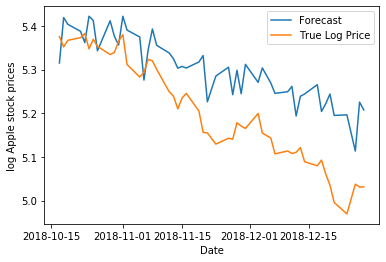

In [14]:
plt.plot(df_test['Forecast'])
plt.plot(df_test['log_price'])
plt.legend(['Forecast', 'True Log Price'])
plt.xlabel('Date')
plt.ylabel('log Apple stock prices')

Text(0, 0.5, 'Apple Stock prices')

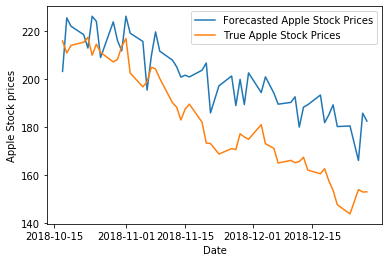

In [15]:
plt.plot(np.exp(df_test['Forecast']))
plt.plot(df_test['Adj Close'])
plt.legend(['Forecasted Apple Stock Prices', 'True Apple Stock Prices'])
plt.xlabel('Date')
plt.ylabel('Apple Stock prices')

In [16]:
from sklearn.metrics import mean_absolute_error
mae_log = mean_absolute_error(df_test['Forecast'], df_test['log_price'])
mae_price = mean_absolute_error(np.exp(df_test['Forecast']), df_test['Adj Close'])
print('MAE for log Apple Stock Prices are: {}'.format(mae_log))
print('MAE for Apple Stock Prices are: {}'.format(mae_price))

MAE for log Apple Stock Prices are: 0.10044594903156182
MAE for Apple Stock Prices are: 18.517356785330254


The Mean Absolute Error of our model is 18.51 <br>
This means:
- On average, our model gets a wrong forecast of $18.51 of the True Apple stock prices
- I believe this is a relatively good forecast given that we did not have a large dataset
- We could improve this model by adding more variables or modeling the 2 time series jointly